In [1]:
#=========================
#MIGUEL DOMINGUEZ
# CSC 59929
# Machine Learning
# Prof. Erik K. Grimmelmann
# Date: 10/09/17
# Homework Week 6
#=========================

In [2]:
# import libraries & setup plotting constants

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
pltC = ('red', 'blue', 'green', 'purple')
pltM = ('o', 'x', '*', '.', '+')

In [3]:
class PolyCalc(object):
    """ Return values of Polynomial """

    def __init__(self):                            
        """ """
        return None
    
    def values(self, coefs, x):
        """ returns y values for given x values       
        
        Parameters
        ----------
            coefs : {array-like}, shape = [deg+1]   
            x     : {array-like}, shape = [npts]
            
        """        
        deg1 = len(coefs)
        deg = deg1 - 1
        npts = len(x)        
        polyval = np.zeros(npts)
        for j in range(0, npts):
            polyval[j] = coefs[0]
            for k in range(1, deg1):
                polyval[j] +=  coefs[k] * x[j]**k  
        return (polyval)


In [4]:
# now prepare to generate a sample generated by a polynomial with random noise.

In [5]:
# set up the polynomial

ncoefs = 4
coefs = np.zeros(ncoefs)
coefs[0] = -6.0
coefs[1] = 7.0
coefs[2] = 6.0
coefs[3] = -9.0

xpoly = np.linspace(-1.0, 1.0,501)
PC = PolyCalc()
ypoly = PC.values(coefs,xpoly)

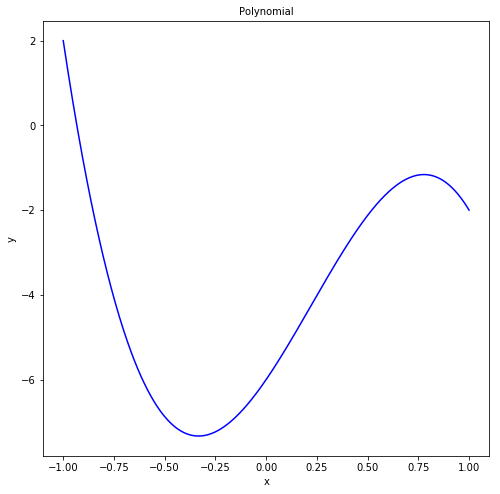

In [6]:
# plot polyn

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypoly, color = pltC[1])
plt.axis(range=1, aspect=1)
plt.show()

In [7]:
# prepare to normalize polynomial and add random noise 

s_tilda = 1.0
n_tilda = 1.0
g = 2.0 /(s_tilda + 2* n_tilda)
s = g * s_tilda
n = g * n_tilda

ymin = ypoly.min()
ymax = ypoly.max()

tr_ = (ymax - ymin)/s
if (tr_ < 0.0001): 
    t = 1000.0
else:
    t = 1/tr_

ypolyt = -1 +(ypoly - ymin)*t + n

cf = np.zeros(4)
cf[0] = -1 +(coefs[0] - ymin)*t + n
for i in range(1,4):
    cf[i] = coefs[i]*t

ypolycheck = PC.values(cf,xpoly)- ypolyt
print('maximum error - should be a very small number: ',np.sqrt((ypolycheck**2).max()))

maximum error - should be a very small number:  2.22044604925e-16


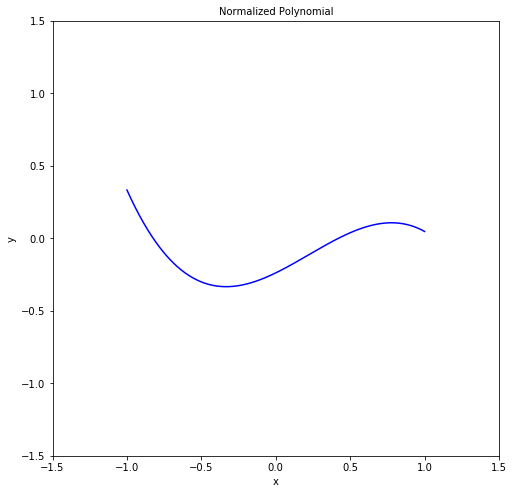

In [8]:
# plot poly

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Normalized Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.axis(range=1, aspect=1)
plt.show()

In [9]:
# generate a sample from a polynomial with random noise.

npts = 1000
sigma = 0.20
x = np.random.uniform(-1.0, 1.0,size = npts)
yrandom = np.random.normal(0.0, sigma, size = npts)

#limit yrandom to range [-1, +1]
for i in range(0,npts):
    if (yrandom[i] > 1.0):
        yrandom[i] = 1.0
    elif (yrandom[i] < -1.0):
        yrandom[i] = -1.0       

y = -1 + (PC.values(coefs,x)- ymin)*t +n + yrandom*n




In [10]:
# divide data into training and test sets

fractest = 0.50
ntest = int(fractest * npts)
ntrain = npts - ntest

# set up and randomize index array
# if index is < 0, it's a test value; if it's >=0 it's a training value
s = np.arange(-ntest, npts-ntest)
np.random.shuffle(s)

x_train = np.zeros(ntrain)
y_train = np.zeros(ntrain)
x_test = np.zeros(ntest)
y_test = np.zeros(ntest)

# there is probably a more elegant way of writing the following code

for i in range(0,npts):
    if (s[i] < 0):
        x_test[-1-s[i]] = x[i]
        y_test[-1-s[i]] = y[i]
    else:
        x_train[s[i]] = x[i]
        y_train[s[i]] = y[i]

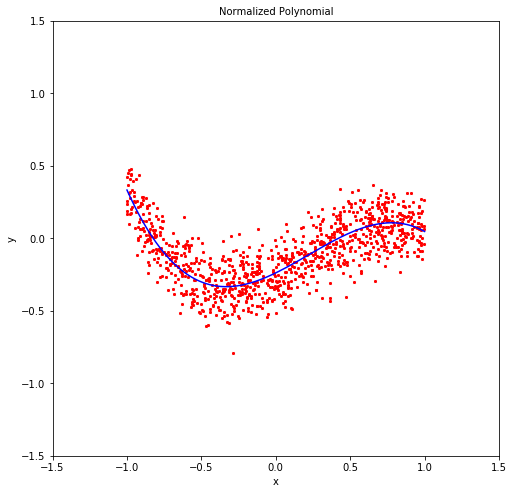

In [11]:
# plot points and polynomial curve

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Normalized Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.scatter(x,y, color = pltC[0], marker = pltM[1], s=5)
plt.axis(range=1, aspect=1)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

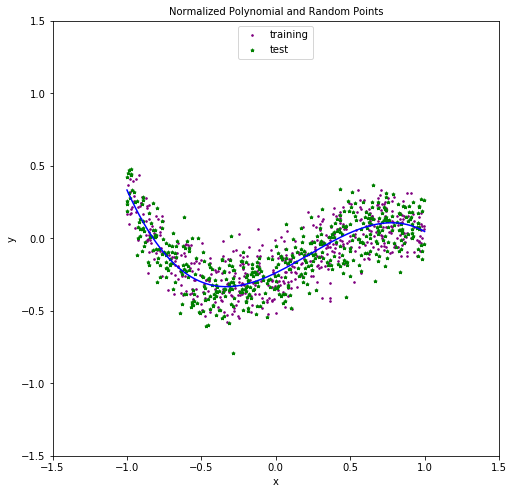

In [12]:
# plot points and curve

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Normalized Polynomial and Random Points', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training', s=10)
plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=10)
plt.legend(loc='upper center', fontsize='medium')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
# plt.axis(range=1, aspect=1)
plt.show()

In [18]:
class PolyFit(object):
    """ Polynomial Fit to a curve

    Parameters
    ------------
    eta : float
        Fitting rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    lambda_reg   : regularization parameter (is set to 1.0 for reg_type = 0)
    reg_type: regularization type
        0: none
        1: L1
        2: L2
    power_weight: boolean
        Determines if power weighting should be applied
    power: int
        Given power for weighthing, default is 1
    
    Attributes
    -----------
    c : 1d-array
        Polynomial coefficeints.
    cost_hist : list
        root-mean-squared error in every epoch.
    grad_hist : list
        magnitude of the cost gradient in every epoch

    """
    def __init__(self, batchsize=1, eta=0.1, n_iter=500, lambda_reg=0.0, reg_type=0, power_weight = False, power = 1):
        self.batchsize = batchsize
        self.eta = eta
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg
        self.reg_type = reg_type
        self.power_weight = power_weight
        self.power = power
        return(None)
    
    def fit(self, deg, x, y):
        """ Fit curve in batch mode

        Parameters
        ----------
        deg: degree of the polynomial [integer]
        x : {array-like}, shape = [n_samples]
            x values of the curve
        y : {array-like}, shape = [n_samples]
            y values of the curve       
        
        Returns
        -------
        self : object

        """
        
        n_val = len(x)
        self.deg = deg
        self.deg1 = deg + 1
        self.c = np.zeros(deg+1)
        self.cost_hist = []
        self.grad_hist = []
        xbatch = np.zeros(n_val)
        ybatch = np.zeros(n_val)
        
        for n in range(self.n_iter):
            g = self.g(x)
            errors = (y - g)            
                        
            # create a batch
            if (self.batchsize >= n_val):
                # use all values
                xbatch = x
                ybatch = y          
            else:
                # use self.batchsize values
                s = np.arange(0,n_val)
                np.random.shuffle(s)
                xbatch = x[s[:self.batchsize]]
                ybatch = y[s[:self.batchsize]]
            # calculate gradient for batch and update the coefficients   
            gradient = self.gradcost(xbatch, ybatch)
            self.c -= self.eta * gradient
            cost = (errors**2).sum() 
            rmscost = np.sqrt(cost/n_val)
            self.cost_hist.append(rmscost)
            gradmag = np.sqrt(np.dot(gradient,gradient))    
            self.grad_hist.append(gradmag)
        return self
    
    def g(self, x):
        """ returns g values for given x values """
        nval = len(x)
        g_val = np.zeros(nval)
        for j in range(0, nval):
            g_val[j] = self.c[0]
            for k in range(1, self.deg1):
                g_val[j] +=  self.c[k] * x[j]**k  
        return (g_val)
    
    def cost(self, x, y):
        """ return cost cost function for a given x, y """
        n_val = len(x)
        cost_val = (0.5 / n_val) *  ((y - g(x))**2).sum()
        
        if (self.reg_type == 2): #L2 REGULARIZATION
            for j in range (1, self.deg1):
                
                if self.power_weight:
                    weight = (j**self.power) #apply weight
                else:
                    weight = 1 #if no power, then weight 1 will not affect calculations
                    
                cost_val += 0.5 * self.lambda_reg * self.c[j]**2 * weight
                
        elif(self.reg_type == 1): #L1 REULARIZATION
            for j in range (1, self.deg1):
                
                if self.power_weight:
                    weight = (j**self.power) #apply weight
                else:
                    weight = 1
                    
                cost_val += 0.5 * self.lambda_reg * abs(self.c[j]) * weight
        return(cost_val)
        
    def gradcost(self, x, y):
        """ returns the gradient for a sample of given x values """
        n_val = len(x)
        self.grad = np.zeros(self.deg1) 
        for m in range(0, self.deg1):                              
            self.grad[m] = - (1/n_val) * ((y - self.g(x))*x**m).sum()
            if (m > 0):
                if (self.reg_type == 2): #L2
                    
                    if self.power_weight:
                        weight = (m**self.power) #apply weight
                    else:
                        weight = 1 #if no power, then weight 1 will not affect calculations
                    
                    self.grad[m] += self.lambda_reg * self.c[m] * weight
                    
                elif (self.reg_type == 1): #L1
                    
                    if self.power_weight:
                        weight = (m**self.power) #apply weight
                    else:
                        weight = 1 #if no power, then weight 1 will not affect calculations
                        
                    self.grad[m] += self.lambda_reg * weight
        return(self.grad)
    
    def gerr(self, x, y):
        """ return the root-mean-squared error of given x and and y values """
        n_val = len(x)             
        perr = y - self.g(x)  
        rmserr = np.sqrt((perr**2).sum()/n_val) 
        return (rmserr)
    
    def getcoef(self):
        """ get the coefficents """
        return(self.c)
    
    def setcoef(self,coef):
        """ set the coefficients """ 
        self.c = coef
        return 

degree:          0
sample size:     500
parameters:      1
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      2500000
train rms error: 0.21280077342
test rms error:  0.221607235934


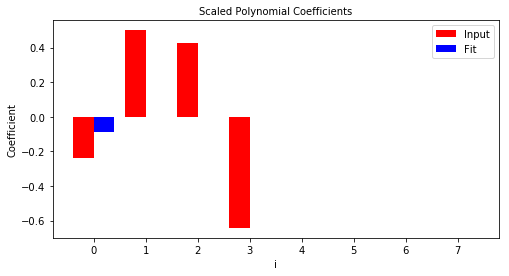

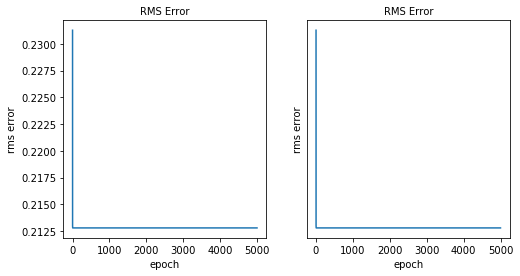

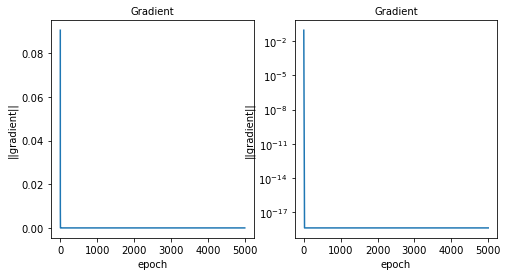

 
degree:          1
sample size:     500
parameters:      2
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      5000000
train rms error: 0.203147116038
test rms error:  0.211135598209


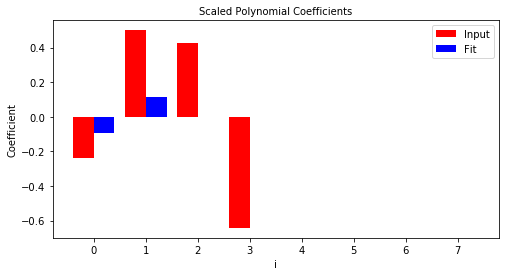

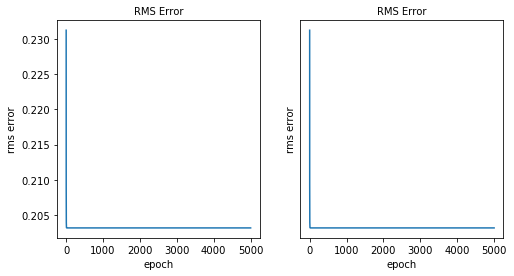

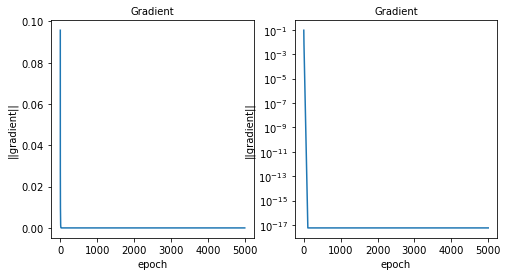

 
degree:          2
sample size:     500
parameters:      3
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      7500000
train rms error: 0.160095087843
test rms error:  0.163889526327


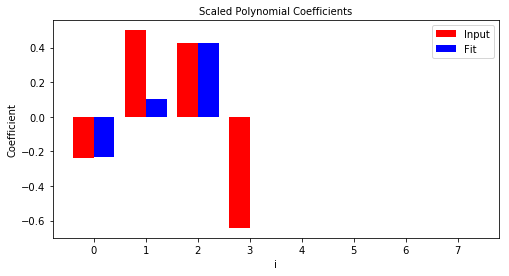

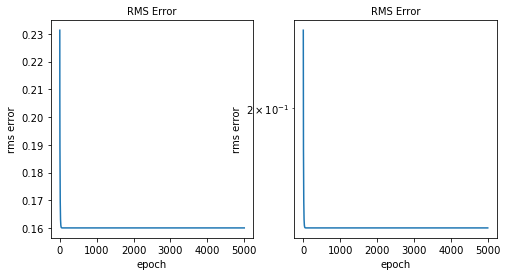

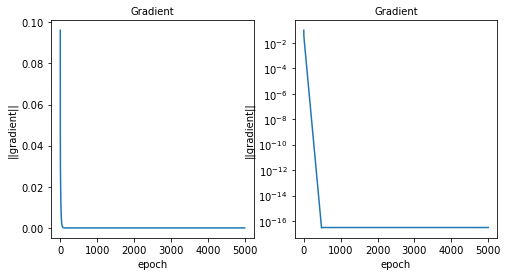

 
degree:          3
sample size:     500
parameters:      4
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      10000000
train rms error: 0.130219064677
test rms error:  0.133270443163


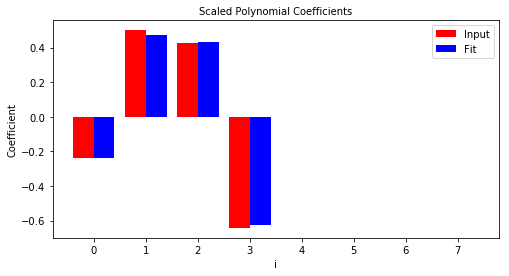

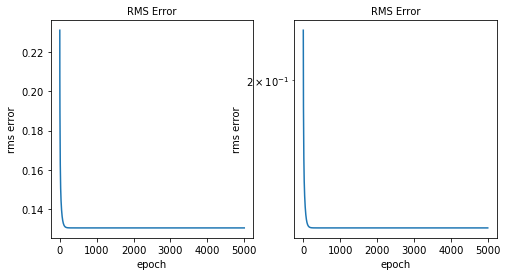

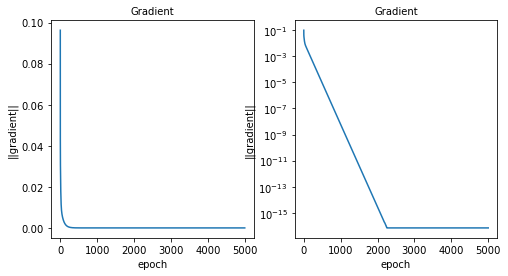

 
degree:          4
sample size:     500
parameters:      5
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      12500000
train rms error: 0.13002159671
test rms error:  0.133816396188


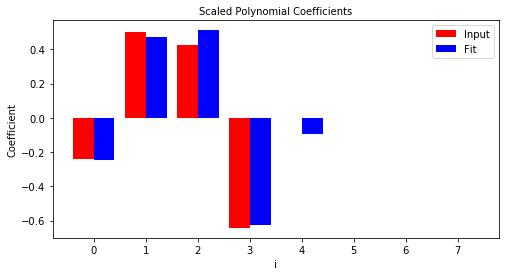

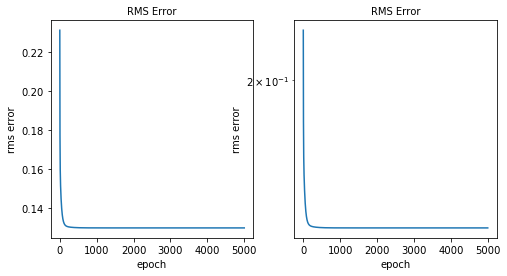

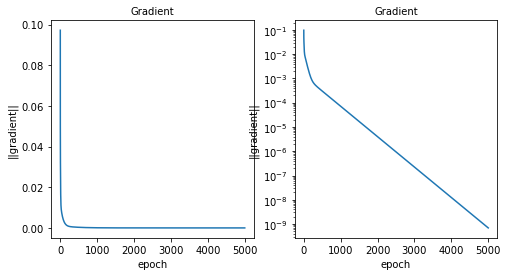

 
degree:          5
sample size:     500
parameters:      6
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      15000000
train rms error: 0.130013575978
test rms error:  0.133854438844


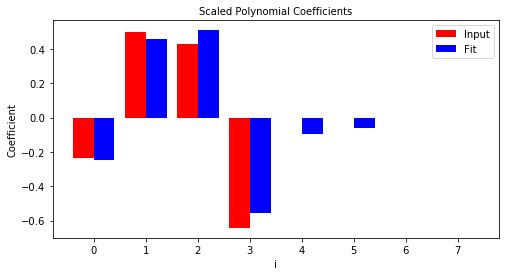

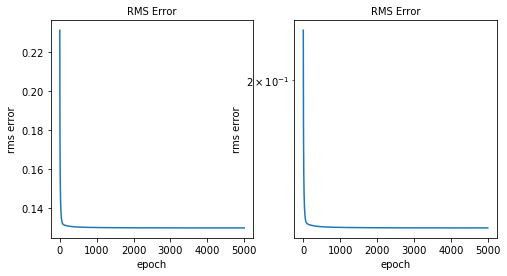

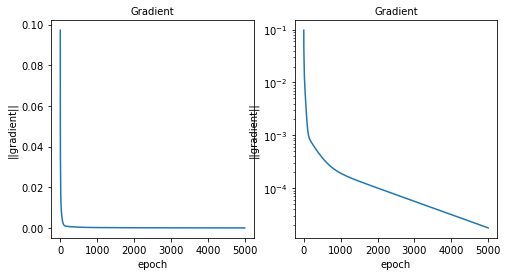

 
degree:          6
sample size:     500
parameters:      7
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      17500000
train rms error: 0.130022399037
test rms error:  0.133854947726


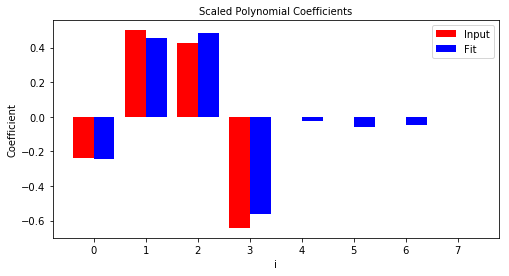

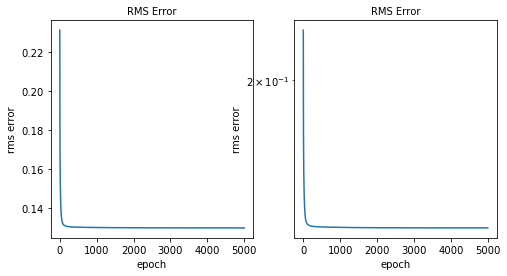

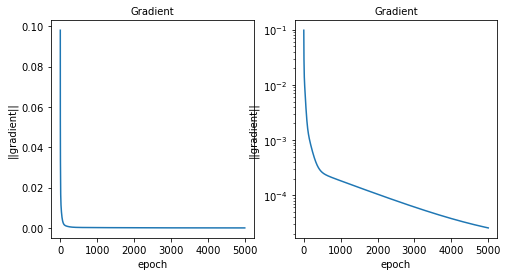

 
degree:          7
sample size:     500
parameters:      8
iterations:      5000
batch size:      100000
eta:             0.5
lambda           0.0
Regularization:  0
inner loop:      20000000
train rms error: 0.129889845281
test rms error:  0.133913446099


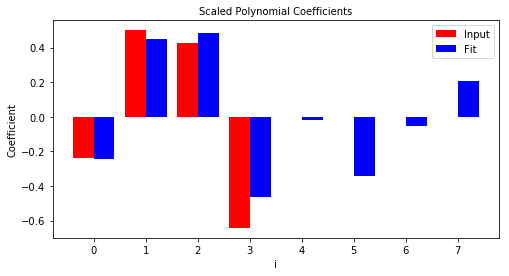

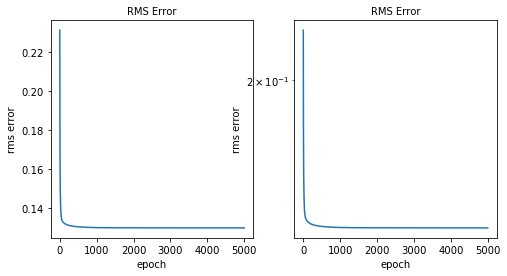

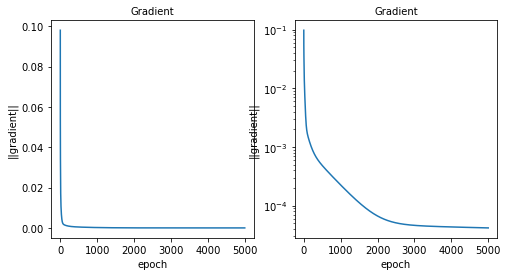

 
done


In [36]:
# fit training data for a variety of polynoical degrees

ndegrees = 7
ndegrees1 = ndegrees+1
degrees = np.arange(0,ndegrees1)
err_train = np.zeros(ndegrees1)
err_test = np.zeros(ndegrees1)
xxx = np.linspace(-1.0, 1.0,501)
yyyi = np.zeros((501,ndegrees1))
yyye = np.zeros((501,ndegrees1))
cffit = np.zeros((ndegrees1))

# assume ndegrees > coefs 
cfinp = np.zeros(ndegrees1)
for i in range(0,ncoefs):
    cfinp[i] = cf[i]
for i in range(ncoefs+1,ndegrees1):
    cfinp[i] = 0    

barwidth = 0.4
xbarinp = np.zeros(ndegrees1)
xbarfit = np.zeros(ndegrees1)
for i in range(0,ndegrees1):
    xbarinp[i] = i - barwidth/2
    xbarfit[i] = i + barwidth/2   
# set parameters

nbatchsize = 100000
niters = 5000
Eta = 0.5
Lvalue = 0.0
RType = 0
costi = np.zeros((niters,ndegrees1))
gradi = np.zeros((niters,ndegrees1))
                 
for i in range (0, ndegrees1):
    
    print('degree:         ', degrees[i])
    print('sample size:    ', ntrain)
    print('parameters:     ', degrees[i]+1)
    print('iterations:     ', niters)
    print('batch size:     ', nbatchsize)
    print('eta:            ', Eta )
    print('lambda          ', Lvalue)
    print('Regularization: ', RType)
    print('inner loop:     ', min(nbatchsize,ntrain)*(degrees[i]+1)*niters)
    #=========================
    #Testing different models!
    
    #NO Regularization (Version 1)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=0.0, reg_type=0)
    
    #NO Regularization (Version 2)
    #PF = PolyFit(batchsize=100000, eta=0.7, n_iter=3500, lambda_reg=0.0, reg_type=0)
    
    #NO Regularization (Version 3)
    #PF = PolyFit(batchsize=100000, eta=0.9, n_iter=5000, lambda_reg=0.0, reg_type=0)
    
    # L2 Regularization without power parameter (Version 1)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=(1/500), reg_type=2)
    
    # L2 Regularization without power parameter (Version 2)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=0.99999, reg_type=2)
    
    # L2 Regularization without power parameter (Version 3)
    #PF = PolyFit(batchsize=100000, eta=0.8, n_iter=4000, lambda_reg=0.555, reg_type=2)
    
    # L2 Regularization power parameter (Version 1)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=0.002, reg_type=2, power_weight=True, power=1)
    
    # L2 Regularization power parameter (Version 2)
    #PF = PolyFit(batchsize=100000, eta=0.9, n_iter=4500, lambda_reg=0.00001, reg_type=2, power_weight=True, power=1)
    
    # L2 Regularization power parameter (Version 3)
    #PF = PolyFit(batchsize=100000, eta=0.1, n_iter=7000, lambda_reg=0.000000000001, reg_type=2, power_weight=True, power=1)
    
    # L1 Regularization without power parameter (Version 1)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=(1/500), reg_type=1)
    
    # L1 Regularization without power parameter (Version 2)
    #PF = PolyFit(batchsize=100000, eta=0.9, n_iter=5000, lambda_reg=(1/100000000000000000), reg_type=1)
    
    # L1 Regularization without power parameter (Version 3)
    #PF = PolyFit(batchsize=100000, eta=0.3, n_iter=2000, lambda_reg=0.777, reg_type=1)
    
    # L1 Regularization power parameter (Version 1)
    #PF = PolyFit(batchsize=100000, eta=0.5, n_iter=3000, lambda_reg=0.002, reg_type=1, power_weight=True, power=1)
    
    # L1 Regularization power parameter (Version 2)
    #F = PolyFit(batchsize=100000, eta=0.9, n_iter=4500, lambda_reg=0.00001, reg_type=1, power_weight=True, power=1)
    
    # L1 Regularization power parameter (Version 3)
    PF = PolyFit(batchsize=100000, eta=0.9,n_iter=5000,lambda_reg=0.000000000001, reg_type=1, power_weight=True, power=1)
    
    PF.fit(degrees[i], x_train, y_train)
    gerr = PF.gerr(x_train, y_train)
    perr = PF.gerr(x_test, y_test)
    err_train[i] = gerr
    err_test[i] = perr  
    yyyi[:,i] = PF.g(xxx)
    yyye[:,i] = yyyi[:,i] - ypolyt[:] 
    costi[:,i] = PF.cost_hist[:]
    gradi[:,i] = PF.grad_hist[:]
    
    print('train rms error:', gerr)
    print('test rms error: ', perr)

# plot coefficients
    for j in range(0,ndegrees1):
        if (j <= degrees[i]):
            cffit[j] = PF.c[j]           
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
    ax.bar(xbarinp, cfinp, barwidth, color = 'red', align='center', label='Input')
    ax.bar(xbarfit, cffit, barwidth, color = 'blue', align='center', label='Fit')
    ax.set_xlabel('i')
    ax.set_ylabel('Coefficient')
    ax.legend(loc='upper right', fontsize='medium')
    ax.set_title('Scaled Polynomial Coefficients', fontsize ='medium')
    plt.show()   
# plot rms error by epoch   
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('rms error')
    ax[0].set_title('RMS Error', fontsize ='medium')
    ax[0].plot(range(1, niters + 1),costi[:,i])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('rms error')
    ax[1].set_title('RMS Error', fontsize ='medium')
    ax[1].semilogy(range(1, niters + 1),costi[:,i])
    plt.show()
# plot ||gradient|| by epoch
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('||gradient||')
    ax[0].set_title('Gradient', fontsize ='medium')
    ax[0].plot(range(1, niters + 1),gradi[:,i])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('||gradient||')
    ax[1].set_title('Gradient', fontsize ='medium')
    ax[1].semilogy(range(1, niters + 1),gradi[:,i])
    plt.show()
    
    print(' ')
print ('done')

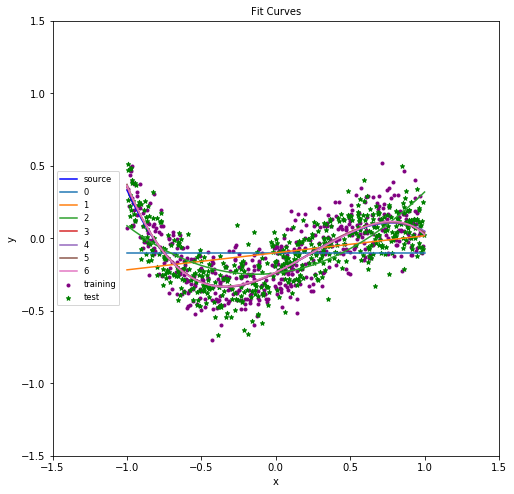

In [42]:
# plot the results

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Fit Curves', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
for i in range(0, ndegrees):
    plt.plot(xxx,yyyi[:,i], label=degrees[i])
plt.legend(loc='center left', fontsize='small')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis(range=1, aspect=1)
plt.show()

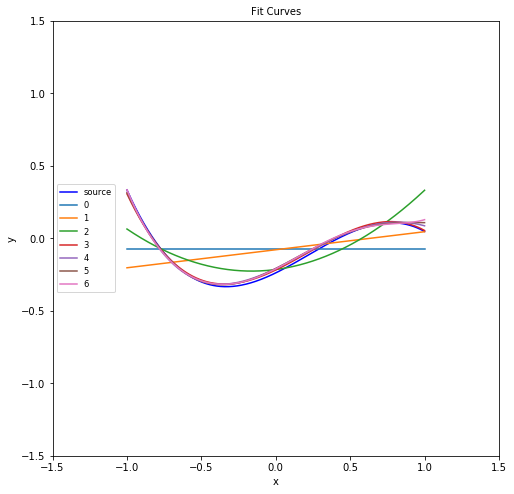

In [16]:
# plot the results without the input sample

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Fit Curves', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
for i in range(0, ndegrees):
    plt.plot(xxx,yyyi[:,i], label=degrees[i])
plt.legend(loc='center left', fontsize='small')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis(range=1, aspect=1)
plt.show()

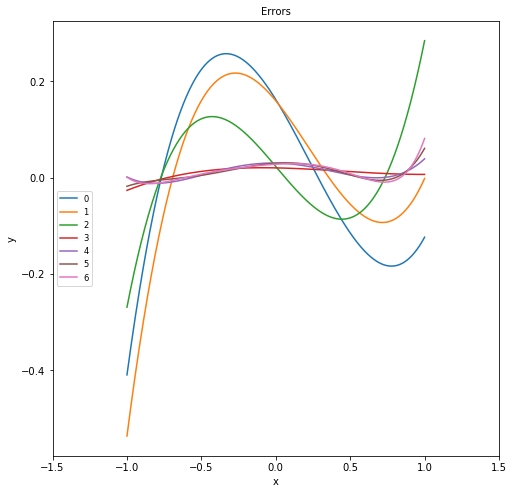

In [17]:
# plot the errors

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Errors', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
#plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
#plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
#plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
for i in range(0, ndegrees):
    plt.plot(xxx,yyye[:,i], label=degrees[i])
plt.legend(loc='center left', fontsize='small')
plt.xlim(-1.5,1.5)
#plt.ylim(-1.5,1.5)
plt.axis(range=1, aspect=1)
plt.show()

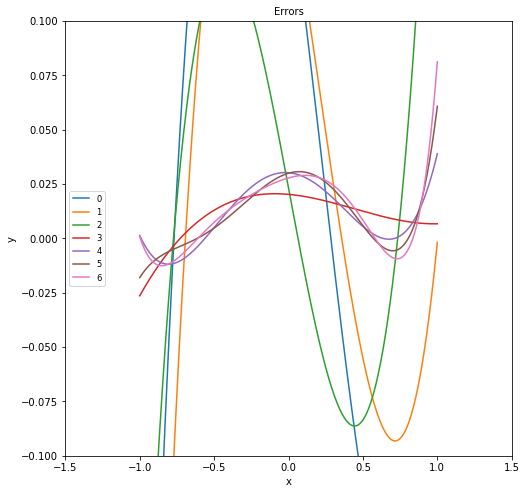

In [18]:
# plot the errors in more detail

plt.close('all')
plt.figure(figsize=(8, 8))
plt.title('Errors', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
#plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
#plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
#plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
for i in range(0, ndegrees):
    plt.plot(xxx,yyye[:,i], label=degrees[i])
plt.legend(loc='center left', fontsize='small')
plt.xlim(-1.5,1.5)
plt.ylim(-0.1,0.1)
plt.axis(range=1, aspect=1)
plt.show()

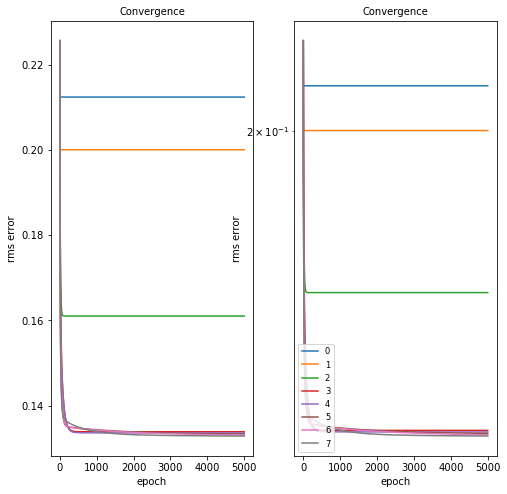

In [19]:
#plot rms error
plt.close('all')
 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,8))
for i in range(0,ndegrees1):
    ax[0].plot(range(1, niters + 1),costi[:,i], label=degrees[i])
    ax[1].semilogy(range(1, niters + 1),costi[:,i], label=degrees[i])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('rms error')
ax[0].set_title('Convergence', fontsize ='medium')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('rms error')
ax[1].set_title('Convergence', fontsize ='medium')
ax[1].legend(loc='lower left', fontsize='small')
plt.show()


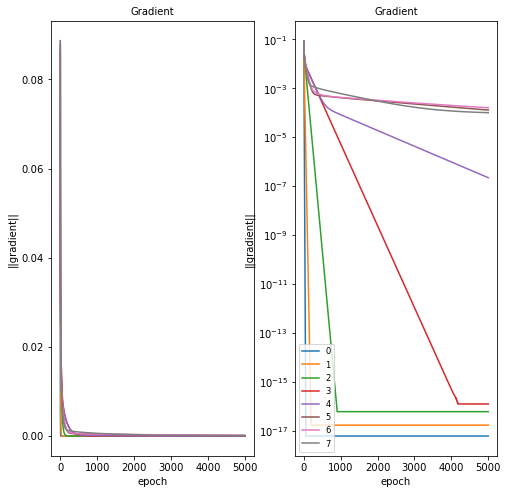

In [20]:
#plot ||gradient||
plt.close('all')
 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,8))
for i in range(0,ndegrees1):
    ax[0].plot(range(1, niters + 1),gradi[:,i], label=degrees[i])
    ax[1].semilogy(range(1, niters + 1),gradi[:,i], label=degrees[i])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('||gradient||')
ax[0].set_title('Gradient', fontsize ='medium')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('||gradient||')
ax[1].set_title('Gradient', fontsize ='medium')
ax[1].legend(loc='lower left', fontsize='small')
plt.show()


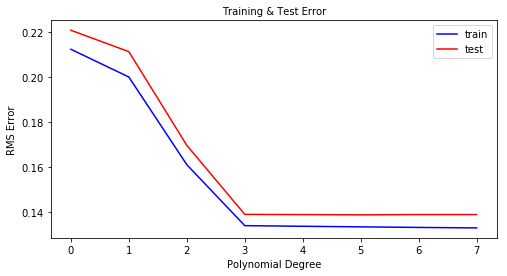

In [21]:
# plot training and test errors

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
ax.plot(degrees, err_train, color='blue', label='train')
ax.plot(degrees, err_test, color='red', label='test')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('RMS Error')
ax.legend(loc='upper right', fontsize='medium')
ax.set_title('Training & Test Error', fontsize ='medium')
plt.show()